In [1]:
from pathlib import Path
BASE_DIR     = Path('/content/drive/MyDrive/structure')

def init_environment(forzar_drive=False):
  # 1) Montar Google Drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=forzar_drive)

  # 2) Rutas base
  MODELS_DIR   = BASE_DIR / 'models'

  # 3) Path y sys.path
  import sys
  sys.path.append(str(MODELS_DIR))
  sys.path.append(str(BASE_DIR))

Mounted at /content/drive
⬇️  Descargando «carlosandres069/5mods-5clases-snr8-12-taps1-phase0-45» …
Dataset URL: https://www.kaggle.com/datasets/carlosandres069/5mods-5clases-snr8-12-taps1-phase0-45


100%|██████████| 591M/591M [00:03<00:00, 175MB/s] 



✅ Usando archivo HDF5: datasets/kaggle/5Mods_5Clases_snr8_12_taps1_phase0_45.hdf5
[SKIP] Rep: 0 (single‐split) → ya existe classification_report.json.
✅ Usando archivo HDF5: datasets/kaggle/5Mods_5Clases_snr8_12_taps1_phase0_45.hdf5
[SKIP] Rep: 1 (single‐split) → ya existe classification_report.json.
✅ Usando archivo HDF5: datasets/kaggle/5Mods_5Clases_snr8_12_taps1_phase0_45.hdf5
[SKIP] Rep: 2 (single‐split) → ya existe classification_report.json.

=== Resumen de evaluación por Fold ===
          loss  accuracy
None  1.609438  0.199707
None  1.609438  0.200195
None  1.609438  0.200195
mean  1.609438  0.200033
std   0.000000  0.000282

=== Métricas promedio de Clasificación ===
             precision  recall  f1-score
class                                   
16qam         0.000000     0.0  0.000000
32qam cross   0.000000     0.0  0.000000
64qam         0.000000     0.0  0.000000
bpsk          0.200033     1.0  0.333378
qpsk          0.000000     0.0  0.000000


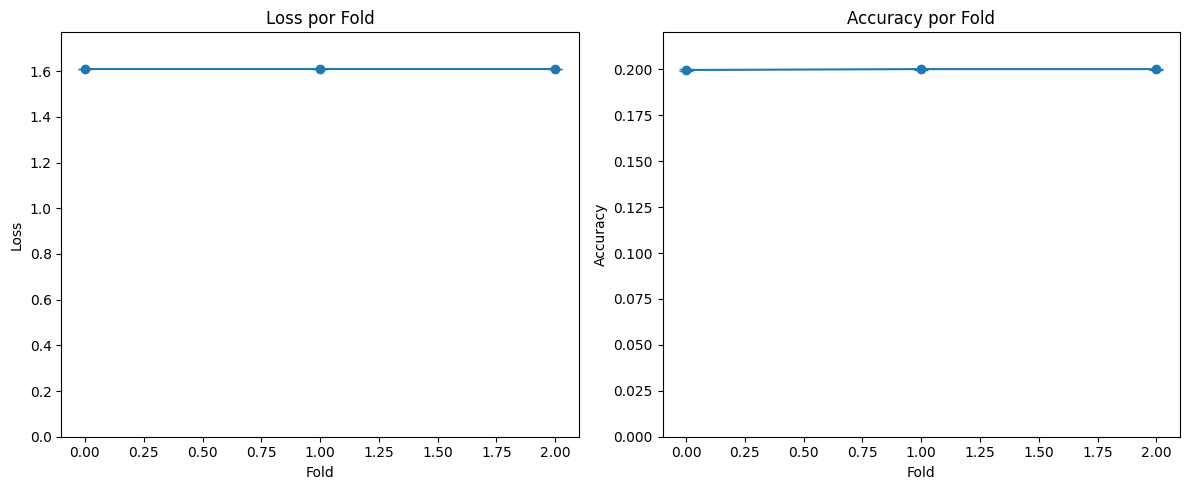

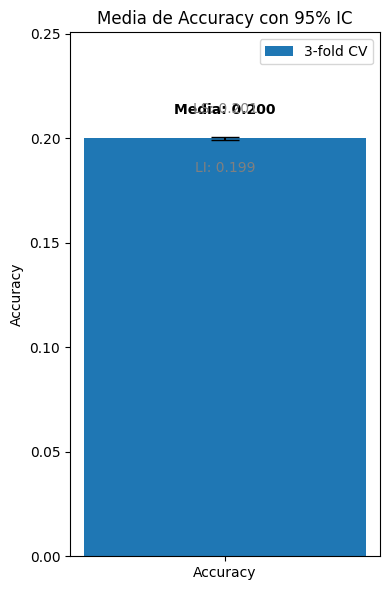






===============  | PROCESO FINALIZADO CORRECTAMENTE |  ===============







In [2]:
# =============================================================================
# 🚀 Notebook principal de experimentación con TensorFlow/Keras
# =============================================================================

# 1) Preparar el entorno
#    - Monta Google Drive
#    - Ajusta sys.path para encontrar tus módulos en models/ y utils/
init_environment(forzar_drive=True)

# 2) Definir experimento
#    El nombre debe coincidir con un archivo YAML en configs/experiments/
exp_name = "< EXP >"

# 3) Cargar configuración
from utils.experiment.functions import load_config, load_experiment
cfg = load_config(exp_name)

# 4) ¿Single-split o K-Fold? | Repeticiones
k = cfg["dataset"].get("k_folds")
repeats = cfg["experiment"].get("repeats")

for rep in range(repeats):

  if k is None or k <= 1:

      # —————————————— 4A) Flujo único ——————————————

      #  4A.1) Cargar experimento
      cfg, NNClass, params, dataset, train_data, val_data, test_idx = \
          load_experiment(exp_name, repeat_index=rep)

      #  4A.1.1) Revisar que 'rep' actual no haya sido previamente ejecutado
      #   Si ya existe classification_report.json  → SALTAR
      rep_report = BASE_DIR / Path(cfg['experiment']['output_subdir']) / "reports" / "classification_report.json"
      if rep_report.exists:
        print(f"[SKIP] Rep: {rep} (single‐split) → ya existe classification_report.json.")
        continue

      #  4A.2) Instanciar y Entrenar
      model   = NNClass(cfg, **params)

      if rep == 0:
        #  4A.3 ) Mostrar resumen de la configuración
        from utils.misc.functions import print_exp_configuration
        print(f"\n✔️ Experimento «{cfg['experiment']['name']}» cargado con éxito.\n")
        print_exp_configuration(cfg)

        #  4A.4) Mostrar arquitectura del modelo
        print("\n📋 Arquitectura del modelo:")
        model.model.summary()

      print("\n"*5)
      print(f"\n🔄 Rep {rep+1}/{repeats}")
      #  4A.5) Entrenamiento (o retomar desde último checkpoint)
      history = model.fit(train_data, val_data)

      #  4A.6) Análisis resultados individual
      from utils.analysis.analysis import ExperimentAnalyzer
      analyzer = ExperimentAnalyzer(
            model=model.model,
            history=history,
            test_data=test_idx,
            cfg=cfg,
            effects=dataset.get_effects("test"),
            show_plots=False,
        )

      analyzer.classification_report()
      analyzer.effect_report()
      analyzer.confusion_matrix(normalize="true")

  else:
      # —————————————— 4B) Flujo K-Fold ——————————————
      if rep == 0:
        #  4B.1) Cargar experimento con primer FOLD INDEX (fines informativos en consola)
        cfg, NNClass, params, _, _, _, _ = load_experiment(exp_name, fold_index=0, repeat_index=0)

        #  4B.2) Instanciar para obtener modelo y poder imprimir parámetros
        model   = NNClass(cfg, **params)

        #  4B.3 ) Mostrar resumen de la configuración
        from utils.misc.functions import print_exp_configuration
        print(f"\n✔️ Experimento «{cfg['experiment']['name']}» cargado con éxito.\n")
        print_exp_configuration(cfg)

        #  4B.4) Mostrar arquitectura del modelo
        print("\n📋 Arquitectura del modelo:")
        model.model.summary()

      #  4B.5) K-FOLD
      for fold in range(k):
          print("\n"*5)
          print(f"\n🔄 Rep {rep+1}/{repeats} | Fold {fold+1}/{k}")

          #  4B.5.1) Cargar experimento
          cfg, NNClass, params, dataset, train_data, val_data, test_idx = \
              load_experiment(exp_name, repeat_index=rep, fold_index=fold)

          #  4B.5.2) Revisar que 'rep' y 'fold' actual no hayan sido previamente ejecutados
          #   Si ya existe: <output_subdir>/reports/classification_report.json  → SALTAR
          rep_report = BASE_DIR / cfg['experiment']['output_subdir'] / "reports" / "classification_report.json"
          if rep_report.exists:
            print(f"[SKIP] Rep: {rep} Fold: {fold}  → ya existe classification_report.json.")
            continue

          #  4B.5.4) Instanciar y Entrenar
          model   = NNClass(cfg, **params)
          history = model.fit(train_data, val_data)

          #  4B.5.4) Análisis resultados individual
          from utils.analysis.analysis import ExperimentAnalyzer
          analyzer = ExperimentAnalyzer(
              model=model.model,
              history=history,
              test_data=test_idx,
              cfg=cfg,
              fold_index=fold,
              effects=dataset.get_effects("test"),
              show_plots=False,
          )

          # Guardar métricas en JSON
          analyzer.classification_report()
          analyzer.effect_report()
          analyzer.confusion_matrix(normalize="true")


# 5) Análisis Final
from utils.analysis.analysis_kfold import ExperimentRepAnalyzer
analyzer = ExperimentRepAnalyzer(
    cfg=load_config(exp_name)
)
analyzer.report_summary()
analyzer.plot_evaluation()
analyzer.plot_accuracy_summary(confidence=0.95)

print("\n"*4)
print("="*15, " | PROCESO FINALIZADO CORRECTAMENTE | ", "="*15)
print("\n"*4)